### 1 : Importations et Chargement des Données

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os

In [8]:
# Ajout du dossier src au chemin pour importer nos fonctions (si besoin)
sys.path.append(os.path.abspath(os.path.join('..')))
# On importe les fonctions depuis src/features.py
from src.features import calculate_rsi, calculate_macd, calculate_bollinger_bands, add_lags, calculate_log_returns

# Chemin du fichier nettoyé (créé dans le notebook précédent)
input_path = '../data/raw/cleaned_close_prices.csv'

if not os.path.exists(input_path):
    print(f"ERREUR : Le fichier {input_path} est introuvable. Avez-vous exécuté le notebook 1 ?")
else:
    # Chargement
    df = pd.read_csv(input_path, index_col=0, parse_dates=True)
    print("Données chargées avec succès !")
    print(df.head())

Données chargées avec succès !
                 AAPL        MSFT       TSLA        ^GSPC   ^VIX   ^TNX
2020-01-02  72.468254  152.505692  28.684000  3257.850098  12.47  1.882
2020-01-03  71.763741  150.606750  29.534000  3234.850098  14.02  1.788
2020-01-06  72.335556  150.996017  30.102667  3246.280029  13.85  1.811
2020-01-07  71.995354  149.619293  31.270666  3237.179932  13.79  1.827
2020-01-08  73.153473  152.002472  32.809334  3253.050049  13.45  1.874


#### 2 : Création des Features (Indicateurs)

In [9]:
# Liste des actions à traiter
target_tickers = ['AAPL', 'MSFT', 'TSLA']

# Liste pour stocker les résultats
processed_data = []

print("Début du Feature Engineering...")

for ticker in target_tickers:
    print(f"Traitement de l'action : {ticker}")
    
    # On récupère la série de prix pour cette action
    if ticker not in df.columns:
        print(f"  -> Attention : {ticker} non trouvé dans les colonnes.")
        continue
        
    price_series = df[ticker]
    
    # Création d'un DataFrame temporaire pour cette action
    temp_df = pd.DataFrame(index=price_series.index)
    temp_df['Close'] = price_series
    temp_df['Ticker'] = ticker
    
    # --- 1. Cible (Target) : Log Returns ---
    # C'est ce que le modèle devra prédire (ou la direction de ce rendement)
    temp_df['Log_Return'] = calculate_log_returns(temp_df['Close'])
    
    # --- 2. Indicateurs Techniques ---
    temp_df['RSI'] = calculate_rsi(temp_df['Close'])
    temp_df['MACD'], temp_df['MACD_Signal'] = calculate_macd(temp_df['Close'])
    temp_df['BB_Upper'], temp_df['BB_Lower'] = calculate_bollinger_bands(temp_df['Close'])
    
    # --- 3. Mémoire (Lags) ---
    # On donne au modèle les rendements des 5 derniers jours
    temp_df = add_lags(temp_df, 'Log_Return', lags=5)
    
    # --- 4. Contexte Macro (VIX & TNX) ---
    # On ajoute les colonnes VIX et TNX à chaque ligne
    if '^VIX' in df.columns:
        temp_df['VIX'] = df['^VIX']
    if '^TNX' in df.columns:
        temp_df['TNX'] = df['^TNX']
        
    # On ajoute ce bloc à la liste
    processed_data.append(temp_df)

# Fusion de tout en un seul grand tableau
full_df = pd.concat(processed_data)

# Suppression des lignes vides (NaN) créées par les calculs (les 20 premiers jours environ)
full_df.dropna(inplace=True)

print("\nTerminé ! Aperçu des données finales :")
print(full_df.head())
print(f"Dimensions : {full_df.shape}")

Début du Feature Engineering...
Traitement de l'action : AAPL
Traitement de l'action : MSFT
Traitement de l'action : TSLA

Terminé ! Aperçu des données finales :
                Close Ticker  Log_Return        RSI      MACD  MACD_Signal  \
2020-01-30  78.143143   AAPL   -0.001450  63.879017  1.195919     1.006339   
2020-01-31  74.678383   AAPL   -0.045352  49.368881  0.967961     0.998663   
2020-02-03  74.473297   AAPL   -0.002750  42.987530  0.761971     0.951325   
2020-02-04  76.931923   AAPL    0.032480  54.739552  0.788028     0.918666   
2020-02-05  77.559265   AAPL    0.008121  57.618754  0.849508     0.904834   

             BB_Upper   BB_Lower  Log_Return_lag_1  Log_Return_lag_2  \
2020-01-30  79.324867  71.251079          0.020716          0.027896   
2020-01-31  79.225942  71.571017         -0.001450          0.020716   
2020-02-03  78.993879  72.074035         -0.045352         -0.001450   
2020-02-04  78.927076  72.600475         -0.002750         -0.045352   
2020-02-0

#### 1. Analyse des Valeurs Manquantes (Mathématique uniquement)


In [10]:
missing_values = full_df.isnull().sum()
total_missing = missing_values.sum()

print("Rapport des Valeurs Manquantes par Colonne :")
print(missing_values[missing_values > 0]) # Affiche seulement s'il y a des erreurs

if total_missing == 0:
    print("\nQUALITÉ DES DONNÉES : Parfaite. Aucune valeur manquante.")
else:
    print(f"\n ATTENTION : Il reste {total_missing} valeurs manquantes.")


Rapport des Valeurs Manquantes par Colonne :
Series([], dtype: int64)

QUALITÉ DES DONNÉES : Parfaite. Aucune valeur manquante.


#### 2. Analyse de la Corrélation (Feature Selection)

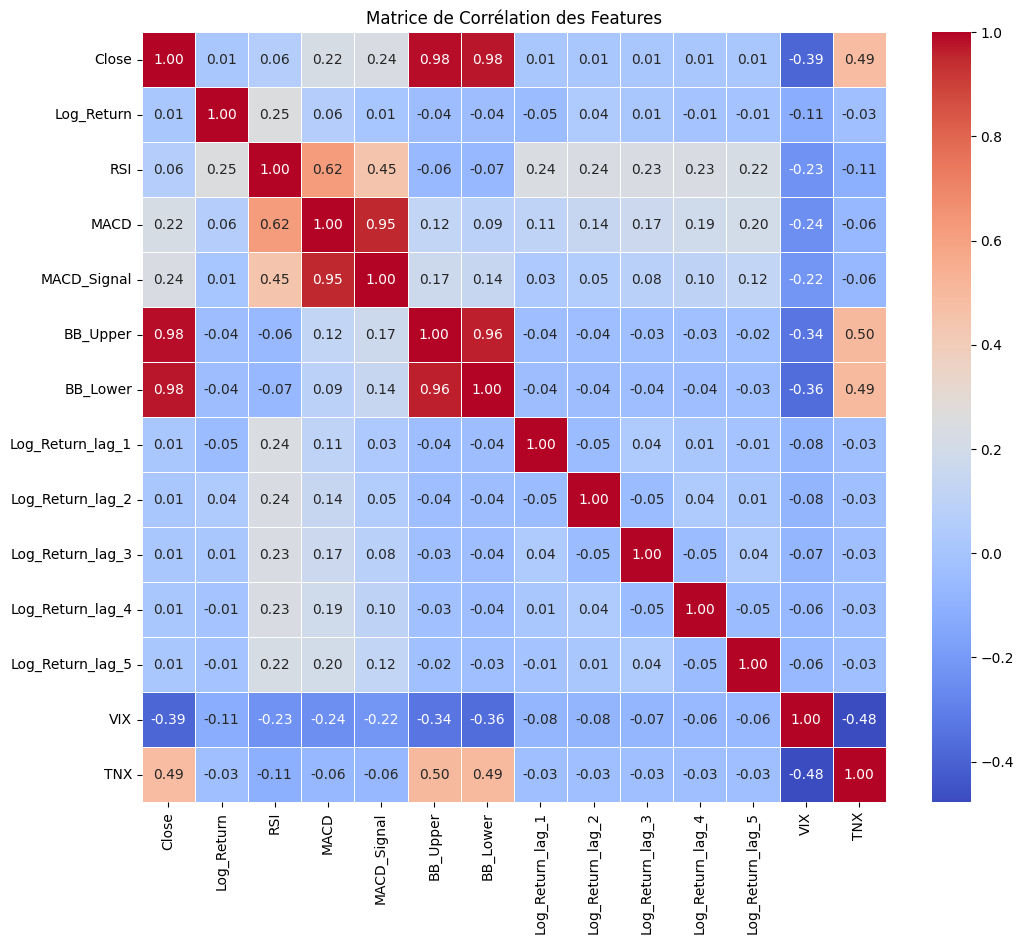

In [11]:
plt.figure(figsize=(12, 10))
correlation = full_df.drop(columns=['Ticker']).corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation des Features")
plt.show()


#### 3. Analyse de l'Équilibrage des Classes (Pour la Classification)


In [12]:
# Si on veut prédire "Hausse" (1) vs "Baisse" (0)
full_df['Direction'] = (full_df['Log_Return'] > 0).astype(int)

# Calcul du ratio
balance = full_df['Direction'].value_counts(normalize=True)
print("\nRépartition des Classes (0=Baisse, 1=Hausse) :")
print(balance)

if abs(balance[0] - balance[1]) < 0.1:
    print("-->  Le dataset est bien équilibré.")
else:
    print("-->  Attention : Déséquilibre de classe détecté.")


Répartition des Classes (0=Baisse, 1=Hausse) :
Direction
1    0.529093
0    0.470907
Name: proportion, dtype: float64
-->  Le dataset est bien équilibré.


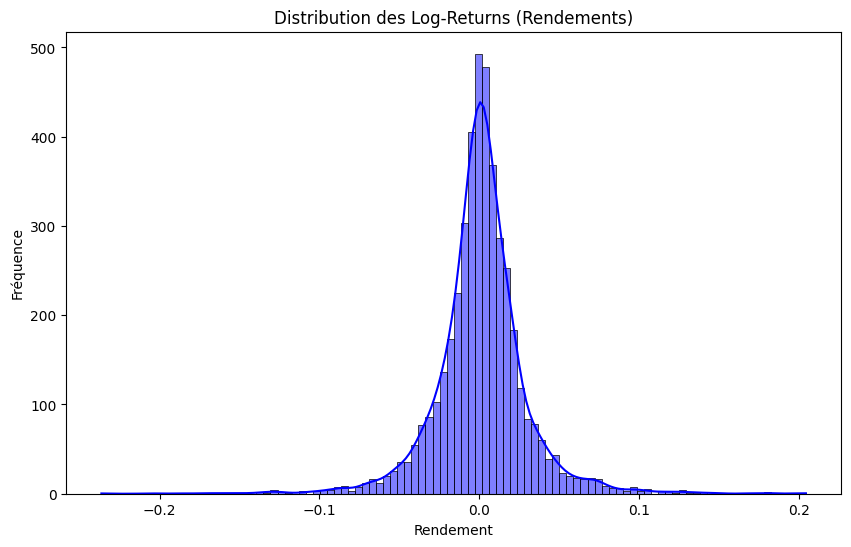

In [13]:
# 4. Visualisation de la distribution des rendements (Log Returns)
plt.figure(figsize=(10, 6))
sns.histplot(full_df['Log_Return'], kde=True, bins=100, color='blue')
plt.title("Distribution des Log-Returns (Rendements)")
plt.xlabel("Rendement")
plt.ylabel("Fréquence")
plt.show()

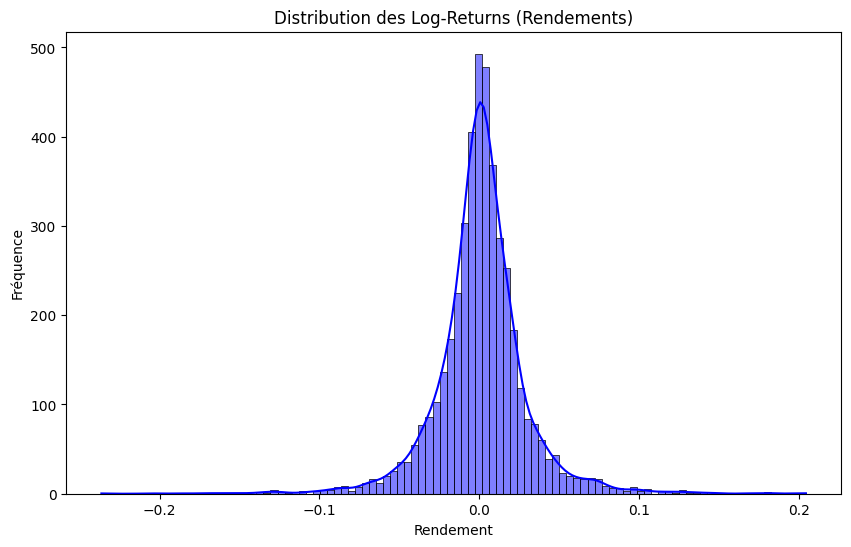

In [14]:
# 4. Visualisation de la distribution des rendements (Log Returns)
plt.figure(figsize=(10, 6))
sns.histplot(full_df['Log_Return'], kde=True, bins=100, color='blue')
plt.title("Distribution des Log-Returns (Rendements)")
plt.xlabel("Rendement")
plt.ylabel("Fréquence")
plt.show()

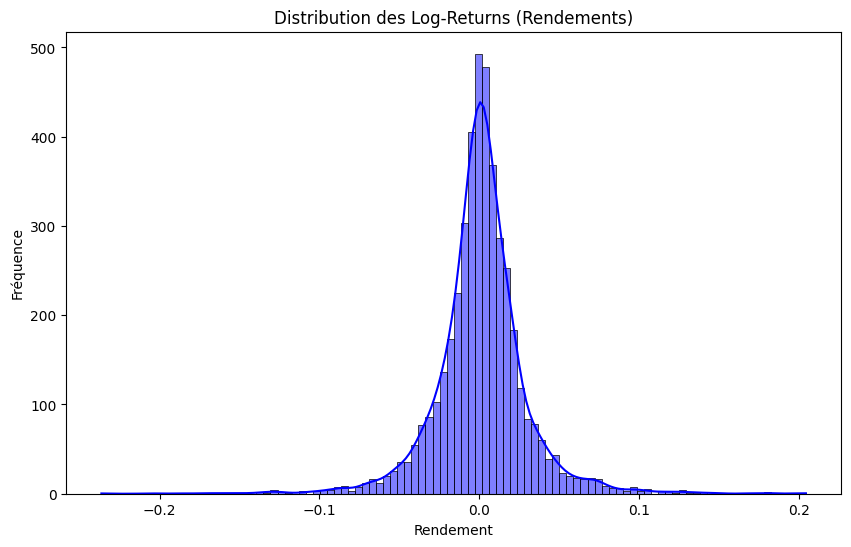

In [ ]:
# 4. Visualisation de la distribution des rendements (Log Returns)
plt.figure(figsize=(10, 6))
sns.histplot(full_df['Log_Return'], kde=True, bins=100, color='blue')
plt.title("Distribution des Log-Returns (Rendements)")
plt.xlabel("Rendement")
plt.ylabel("Fréquence")
plt.show()

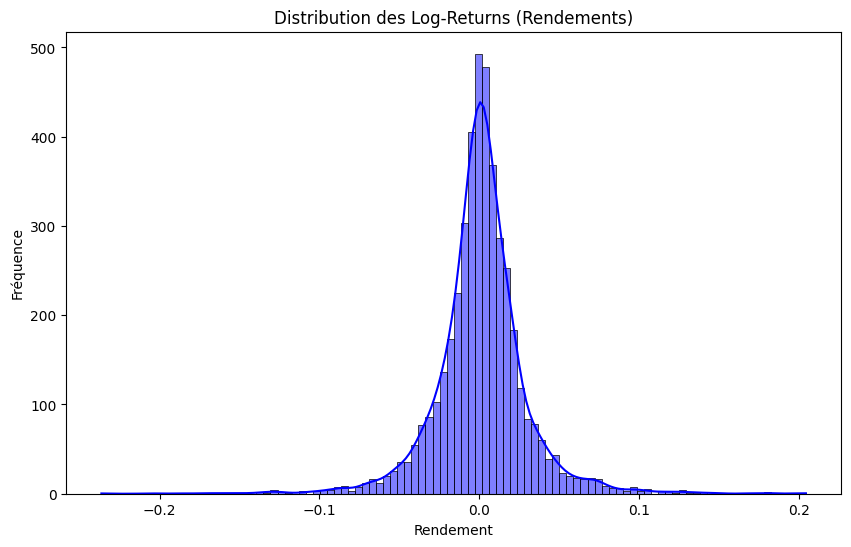

In [ ]:
# 4. Visualisation de la distribution des rendements (Log Returns)
plt.figure(figsize=(10, 6))
sns.histplot(full_df['Log_Return'], kde=True, bins=100, color='blue')
plt.title("Distribution des Log-Returns (Rendements)")
plt.xlabel("Rendement")
plt.ylabel("Fréquence")
plt.show()

In [19]:
# Sauvegarde du dataset prêt pour le Machine Learning
output_dir = '../data/processed'
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(output_dir, 'features.csv')
full_df.to_csv(output_path)

print(f"SUCCÈS : Le fichier '{output_path}' est prêt.")
print(f"Nombre total d'échantillons : {len(full_df)}")

SUCCÈS : Le fichier '../data/processed\features.csv' est prêt.
Nombre total d'échantillons : 4434
